# Text Emotion Classification Using LSTM

## Import the libraries

In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout

## Download the text and label dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Text preprocessing function
str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [ ]:
# Read dataset & Preprocess text
df_train = pd.read_csv('train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

## Data Visualization

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64
Training Counts


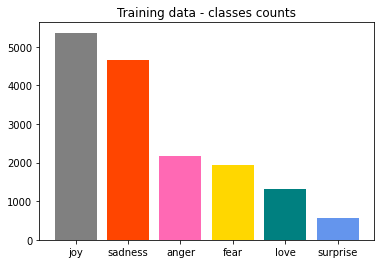

Testing Counts
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: Emotion, dtype: int64


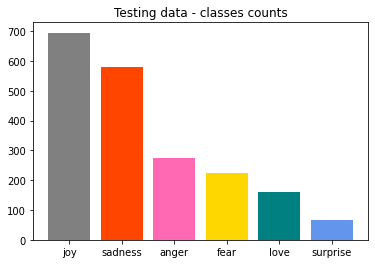

Validation Counts
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: Emotion, dtype: int64


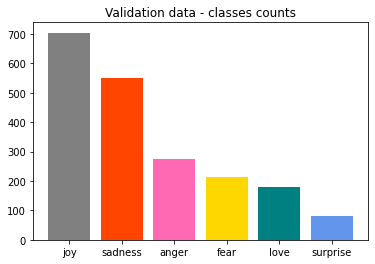

In [ ]:
# Visualize classes counts
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

#y_train value cuonts
y_train_count = pd.Series(y_train).value_counts()
print(y_train_count)
print('Training Counts')
plt.bar(y_train_count.index, y_train_count.values, color = colors)
plt.title("Training data - classes counts")
plt.show()


#y_test value counts
y_test_count = pd.Series(y_test).value_counts()
print('Testing Counts')
print(y_test_count)
plt.bar(y_test_count.index, y_test_count.values, color=colors)
plt.title("Testing data - classes counts")
plt.show()

#y_val value counts
y_val_count = pd.Series(y_val).value_counts()
print('Validation Counts')
print(y_val_count)
plt.bar(y_val_count.index, y_val_count.values, color=colors)
plt.title("Validation data - classes counts")
plt.show()

In [ ]:
#show the first 15 text from X_train
print(X_train[:15].to_markdown())

#show the last 15 text from X_train
print(X_train[-15:].to_markdown())

|    | Text                                                                                                                                                                                                                        |
|---:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | i didnt feel humiliated                                                                                                                                                                                                     |
|  1 | i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake                                                                                                                |
|  2 | im grabbing a minute to post i feel greedy wrong                             

## Label Encoding

In [ ]:
# Encode labels
le = LabelEncoder() #define label encoder
y_train = le.fit_transform(y_train) #fit and transform encoding to y_train
y_test = le.transform(y_test) #encode the y_test
y_val = le.transform(y_val) #encode the y_val

In [ ]:
#y_train, y_test, and y_val encode
y_train, y_test, y_val

(array([4, 4, 0, ..., 2, 0, 4]),
 array([4, 4, 4, ..., 2, 2, 1]),
 array([4, 4, 3, ..., 2, 2, 2]))

## Text tokenization

In [ ]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


## Text embedding

In [ ]:
#Read GloVE embeddings
path_to_glove_file = '/content/drive/MyDrive/Proa-ML/Week6/Assignment/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 15069 words (1115 misses)


## Modeling the text dataset

In [ ]:
# Build neural network architecture

model = Sequential()
model.add(Embedding(input_dim = num_tokens,
                    output_dim = embedding_dim,
                    input_length= X_train.shape[1],
                    weights = [embedding_matrix],
                    trainable = False, 
                    embeddings_initializer="uniform"))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(6, activation = 'softmax'))

adam = Adam(learning_rate=0.005)
#model compile
model.compile(loss = "sparse_categorical_crossentropy",
                optimizer = Adam(learning_rate=0.005),
                metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          3237000   
                                                                 
 dropout (Dropout)           (None, 256, 200)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 256, 256)         336896    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 512)         1050624   
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256, 512)          0

In [ ]:
#Callback
callback = EarlyStopping(monitor='val_loss', min_delta=0.01, patience = 5, restore_best_weights=True)

In [ ]:
# Fit model
history_embedding = model.fit(x = X_train, y = y_train, 
                              epochs = 25, batch_size = 32, 
                              validation_data=(X_val, y_val),
                              verbose = 1, callbacks= [callback]  )

Epoch 1/25
500/500 [==============================] - 52s 83ms/step - loss: 1.3169 - accuracy: 0.5014 - val_loss: 1.0547 - val_accuracy: 0.5885
Epoch 2/25
500/500 [==============================] - 38s 77ms/step - loss: 0.9334 - accuracy: 0.6517 - val_loss: 0.5601 - val_accuracy: 0.7860
Epoch 3/25
500/500 [==============================] - 39s 77ms/step - loss: 0.4039 - accuracy: 0.8623 - val_loss: 0.2086 - val_accuracy: 0.9200
Epoch 4/25
500/500 [==============================] - 39s 78ms/step - loss: 0.2194 - accuracy: 0.9164 - val_loss: 0.1563 - val_accuracy: 0.9300
Epoch 5/25
500/500 [==============================] - 39s 78ms/step - loss: 0.1661 - accuracy: 0.9290 - val_loss: 0.1360 - val_accuracy: 0.9355
Epoch 6/25
500/500 [==============================] - 39s 78ms/step - loss: 0.1553 - accuracy: 0.9323 - val_loss: 0.1433 - val_accuracy: 0.9310
Epoch 7/25
500/500 [==============================] - 40s 79ms/step - loss: 0.1315 - accuracy: 0.9374 - val_loss: 0.1166 - val_accuracy:

## Model evaluation

In [ ]:
#model evaluation
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 2s 32ms/step - loss: 0.1166 - accuracy: 0.9355


[0.11662349104881287, 0.9355000257492065]

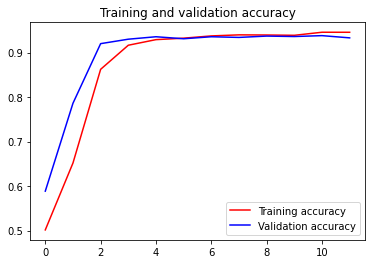

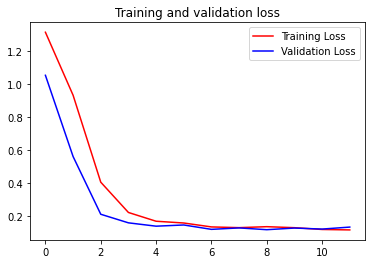

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history_embedding.history['accuracy']
val_acc = history_embedding.history['val_accuracy']
loss = history_embedding.history['loss']
val_loss = history_embedding.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model peformace evaluation

**We got 93% model accuracy, now we check the model peformance with the test data**

In [ ]:
#test prediction result
y_pred =   np.argmax(model.predict(X_test), axis  =  1)
y_pred = le.inverse_transform(y_pred)

#y_test real value
y_true = y_test.copy()
y_true = le.inverse_transform(y_true)

from sklearn import metrics

#classificatin report y prediction and y true
print(metrics.classification_report(y_pred, y_true)) 

              precision    recall  f1-score   support

       anger       0.96      0.89      0.93       297
        fear       0.82      0.99      0.89       185
         joy       0.93      0.96      0.95       675
        love       0.86      0.83      0.84       164
     sadness       0.97      0.97      0.97       584
    surprise       0.97      0.67      0.80        95

    accuracy                           0.93      2000
   macro avg       0.92      0.89      0.90      2000
weighted avg       0.93      0.93      0.93      2000



In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[265,   0,   1,   0,   9,   0],
       [ 11, 183,   0,   0,   5,  25],
       [  8,   0, 649,  27,   5,   6],
       [  0,   0,  23, 136,   0,   0],
       [ 12,   2,   2,   1, 564,   0],
       [  1,   0,   0,   0,   1,  64]])

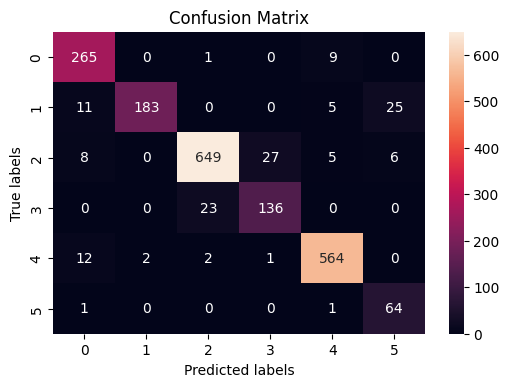

In [ ]:
import seaborn as sns   

#create confution matrix plot
fig, ax = plt.subplots(dpi=100)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

## Model application to the custom text

We try to apply the model with 10 random raw text from the `df_test['Text']`

In [ ]:
# Classify custom sample
import random
sent = df_test['Text'].to_list()
sentences = random.sample(sent, 10)
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n")

i feel like ive been neglectful
sadness : 0.9994540810585022

im feeling rather rotten so im not very ambitious right now
sadness : 0.9982190728187561

i feel quite reluctant to pick up a dance with dragons book because once i m done with that who knows how long i d have to wait for martin to finish his next installment it took him years to release a dance with dragons after a feast for crows
fear : 0.9995352029800415

i thought i would grumpily curse the world and remain angry about oh i don t even really know sometimes it feels like i m angry about absolutely everything
anger : 0.9990494847297668

i feel pretty strongly about not doing a giveaway to gain numbers
joy : 0.5100907683372498

i cannot even begin to express in words the depth of sorrow that i feel having not posted any of my ludicrous rants over the passed days
anger : 0.8495133519172668

i couldn t tell if he was sick injured or just feeling generally awful but he climbed into the team car and abandoned the race right the

In [ ]:
#save the model
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
model.save('Emotion Recognition.h5')